In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys

import h5py
import numpy as np
from astropy.cosmology import Planck18

import py21cmfast as p21c

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
from dm21cm.utils import abscs
from dm21cm.evolve import get_z_edges

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [2]:
! echo $P21C_CACHE_DIR
! ls $P21C_CACHE_DIR

/n/holyscratch01/iaifi_lab/yitians/dm21cm/21cmFAST-cache


pwave_cmp_20241014_log10m8.500_injm2  test
pwave_cmp_20241014_log10m9.000_injm1


In [3]:
! rm -rf $P21C_CACHE_DIR/test

In [4]:
run_name = 'test'
subcycle_factor = 10
z_start = 45.
z_end = 5.
box_dim = 32
box_len = 256. # [Mpc]
n_threads = 32

EPSILON = 1e-6

cache_dir = os.environ['P21C_CACHE_DIR'] + '/' + run_name
p21c.config['direc'] = cache_dir

p21c_initial_conditions = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM = box_dim,
        BOX_LEN = box_len, # [conformal Mpc]
        N_THREADS = n_threads,
        USE_RELATIVE_VELOCITIES = True,
    ),
    cosmo_params = p21c.CosmoParams(
        OMm = Planck18.Om0,
        OMb = Planck18.Ob0,
        POWER_INDEX = Planck18.meta['n'],
        SIGMA_8 = Planck18.meta['sigma8'],
        hlittle = Planck18.h,
    ),
    random_seed = 54321,
    write = True,
)

p21c.global_params.Z_HEAT_MAX = z_start# + EPSILON
p21c.global_params.ZPRIME_STEP_FACTOR = abscs['zplusone_step_factor'] ** subcycle_factor

z_edges_coarse = get_z_edges(z_start, z_end, p21c.global_params.ZPRIME_STEP_FACTOR) # steps for 21cmFAST
z_edges = get_z_edges(z_edges_coarse[0]+EPSILON, z_end, abscs['zplusone_step_factor'])[1:] # steps for DM21cm, with the same first and last redshifts as z_edges_coarse

z_edges_coarse = np.around(z_edges_coarse, decimals = 10) # roundoff to avoid floating point issues, the same is done in 21cmFAST
z_edges = np.around(z_edges, decimals = 10)
scrollz = z_edges_coarse.copy() # used in lightcone construction

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/inputs.py:487: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


In [5]:
! ls $P21C_CACHE_DIR/test

InitialConditions_9ecd27b9b129095906fc37120d7b611a_r54321.h5


In [6]:
perturbed_field = p21c.perturb_field(redshift=z_edges_coarse[0], init_boxes=p21c_initial_conditions, write=True)

In [7]:
! ls $P21C_CACHE_DIR/test

InitialConditions_9ecd27b9b129095906fc37120d7b611a_r54321.h5
PerturbedField_464f99ac270d0333a7a75e3eca4a3d4c_r54321.h5


In [8]:
spin_temp = None
ionized_box = None
astro_params = p21c.AstroParams()
input_heating = None
input_ionization = None
input_jalpha = None

spin_temp = p21c.spin_temperature(
    perturbed_field = perturbed_field,
    previous_spin_temp = spin_temp,
    input_heating_box = input_heating,
    input_ionization_box = input_ionization,
    input_jalpha_box = input_jalpha,
    astro_params = astro_params,
)

ionized_box = p21c.ionize_box(
    perturbed_field = perturbed_field,
    previous_ionize_box = ionized_box,
    spin_temp = spin_temp,
    astro_params = astro_params,
)

brightness_temp = p21c.brightness_temperature(
    ionized_box = ionized_box,
    perturbed_field = perturbed_field,
    spin_temp = spin_temp,
)

In [9]:
! ls $P21C_CACHE_DIR/test

BrightnessTemp_a98ea1b3826c9b1a29f5375ec58b4b4c_r54321.h5
InitialConditions_9ecd27b9b129095906fc37120d7b611a_r54321.h5
IonizedBox_4d710fe16b18cdc6599b43862154cca9_r54321.h5
PerturbedField_464f99ac270d0333a7a75e3eca4a3d4c_r54321.h5
TsBox_ba995307d034b4ab96f257e5d8b4e3a2_r54321.h5


In [19]:
[n for n in dir(p21c_initial_conditions) if not n.startswith('_')]

['compute',
 'cosmo_params',
 'dummy',
 'ensure_arrays_computed',
 'ensure_arrays_inited',
 'ensure_input_computed',
 'exists',
 'fieldnames',
 'fields',
 'filename',
 'find_existing',
 'from_file',
 'get_fieldnames',
 'get_fields',
 'get_pointer_fields',
 'get_required_input_arrays',
 'hires_density',
 'hires_vx',
 'hires_vx_2LPT',
 'hires_vy',
 'hires_vy_2LPT',
 'hires_vz',
 'hires_vz_2LPT',
 'initial',
 'is_computed',
 'load_all',
 'lowres_density',
 'lowres_vcb',
 'lowres_vx',
 'lowres_vx_2LPT',
 'lowres_vy',
 'lowres_vy_2LPT',
 'lowres_vz',
 'lowres_vz_2LPT',
 'patch_version',
 'path',
 'pointer_fields',
 'prepare',
 'prepare_for_perturb',
 'prepare_for_spin_temp',
 'primitive_fields',
 'purge',
 'random_seed',
 'read',
 'refresh_cstruct',
 'save',
 'summarize',
 'user_params',
 'version',
 'write',
 'write_data_to_hdf5_group']

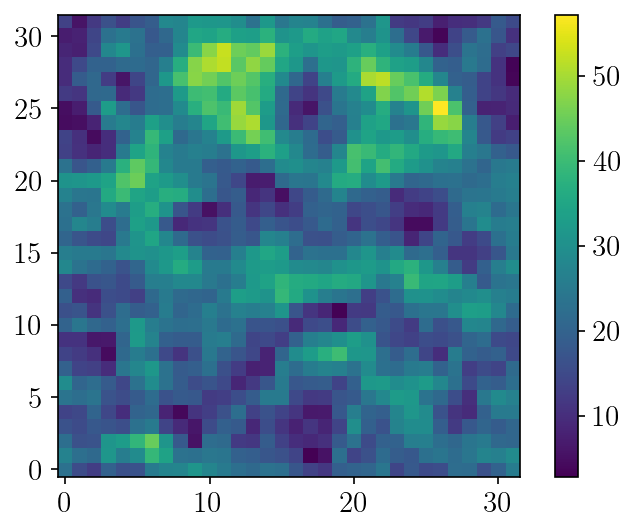

In [23]:
plt.imshow(p21c_initial_conditions.lowres_vcb[0], origin='lower')
plt.colorbar()

In [17]:
brightness_temp.fieldnames

['brightness_temp']

In [18]:
p21c.get_all_fieldnames(as_dict=True)

{'density': 'PerturbedField',
 'velocity': 'PerturbedField',
 'Ts_box': 'TsBox',
 'x_e_box': 'TsBox',
 'Tk_box': 'TsBox',
 'J_21_LW_box': 'TsBox',
 'xH_box': 'IonizedBox',
 'Gamma12_box': 'IonizedBox',
 'MFP_box': 'IonizedBox',
 'z_re_box': 'IonizedBox',
 'dNrec_box': 'IonizedBox',
 'temp_kinetic_all_gas': 'IonizedBox',
 'Fcoll': 'IonizedBox',
 'Fcoll_MINI': 'IonizedBox',
 'brightness_temp': 'BrightnessTemp',
 'input_heating': 'InputHeating',
 'input_ionization': 'InputIonization',
 'input_jalpha': 'InputJAlpha',
 'lowres_density': 'InitialConditions',
 'lowres_vx': 'InitialConditions',
 'lowres_vy': 'InitialConditions',
 'lowres_vz': 'InitialConditions',
 'lowres_vx_2LPT': 'InitialConditions',
 'lowres_vy_2LPT': 'InitialConditions',
 'lowres_vz_2LPT': 'InitialConditions',
 'hires_density': 'InitialConditions',
 'hires_vx': 'InitialConditions',
 'hires_vy': 'InitialConditions',
 'hires_vz': 'InitialConditions',
 'hires_vx_2LPT': 'InitialConditions',
 'hires_vy_2LPT': 'InitialConditions

In [13]:
perturbed_field.fields

{'density': <_cffi_backend.CField at 0x7f34ba9ebd20>,
 'velocity': <_cffi_backend.CField at 0x7f34ba9e88a0>}

# step=1

In [24]:
perturbed_field = p21c.perturb_field(redshift=z_edges_coarse[1], init_boxes=p21c_initial_conditions)

In [25]:
spin_temp = p21c.spin_temperature(
    perturbed_field = perturbed_field,
    previous_spin_temp = spin_temp,
    input_heating_box = input_heating,
    input_ionization_box = input_ionization,
    input_jalpha_box = input_jalpha,
    astro_params = astro_params,
)

ionized_box = p21c.ionize_box(
    perturbed_field = perturbed_field,
    previous_ionize_box = ionized_box,
    spin_temp = spin_temp,
    astro_params = astro_params,
)

brightness_temp = p21c.brightness_temperature(
    ionized_box = ionized_box,
    perturbed_field = perturbed_field,
    spin_temp = spin_temp,
)

In [29]:
ionized_box.fields

{'first_box': <_cffi_backend.CField at 0x7f3474e8b690>,
 'mean_f_coll': <_cffi_backend.CField at 0x7f3474e8b6c0>,
 'mean_f_coll_MINI': <_cffi_backend.CField at 0x7f3474e8b780>,
 'log10_Mturnover_ave': <_cffi_backend.CField at 0x7f34ba9ea640>,
 'log10_Mturnover_MINI_ave': <_cffi_backend.CField at 0x7f34ba9e9170>,
 'xH_box': <_cffi_backend.CField at 0x7f34ba9ea790>,
 'Gamma12_box': <_cffi_backend.CField at 0x7f34ba9eab50>,
 'MFP_box': <_cffi_backend.CField at 0x7f34ba9e8810>,
 'z_re_box': <_cffi_backend.CField at 0x7f34ba9e95c0>,
 'dNrec_box': <_cffi_backend.CField at 0x7f34ba9e8510>,
 'temp_kinetic_all_gas': <_cffi_backend.CField at 0x7f34ba9e8450>,
 'Fcoll': <_cffi_backend.CField at 0x7f34ba9eb990>,
 'Fcoll_MINI': <_cffi_backend.CField at 0x7f34ba9ea880>}